In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#from numpy import *
import numpy as np
import pymongo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def mongoConnection():
    return pymongo.MongoClient().HousingListings.listings

In [63]:
res = mongoConnection().find({"sqft": {"$exists": True}, 
                              "bathrooms": {"$exists": True},
                              "latitude": {"$exists": True},
                              "bedrooms": {"$exists": True},
                              "longitude": {"$exists": True},
                              "numImages": {"$exists": True},
                              "description": {"$exists": True},
                              "postingDate": {"$exists": True}
                             })

In [64]:
#Find price of nearby apartments - average of apartments within 5 blocks.
#Find price of 
len(list(res))

1474

In [56]:
res[450]

{u'_id': ObjectId('56d138082769c30301f380b3'),
 u'address': u'los angeles street at arlington',
 u'bathrooms': 1,
 u'bedrooms': 3,
 u'description': u'\n**OPEN HOUSE - Call for Showing**\nNatural Light-filled Two-story Townhouse 3 bd./1ba. Berkeley/Emeryville Border \nFirst floor has living room, kitchen, laundry and access to backyard. Second floor has 3 bedroom and bathroom.\nVIDEO TOUR!\nViews of Emerville Skyline ,Windows all around -- lots of natural light \n\nGreat Location \n10 Blocks to Ashby BART Biking Distance To U.C. Berkeley \nWalk to Arizmendi, Pixar, and Peets Minutes to Highways 580/880/24, Saturday Farmers market on Grace Avenue 75 feet from your front door \n\nAvailable to move-in January, 2016 \n\nSecurity deposit - 1.5x rent \n\nTenant pays utilities. \n\nPresented by New Parnasa Partners. Please call Raphael @\n\nfor information and viewing.\n\n',
 u'latitude': 37.841826,
 u'link': u'http://sfbay.craigslist.org/eby/apa/5452217433.html',
 u'longitude': -122.27898,
 u

In [3]:
import geopy
from geopy.distance import vincenty
import datetime

now = datetime.datetime.now()
def nowfn():
    global now
    return now
    

def get_distance(lat, lon):
    center = (37.872105, -122.259470)
    return vincenty(center, (lat, lon)).miles 

def featurize(listing):
    
    return [
                listing["bedrooms"], listing['bathrooms'],
                listing["sqft"], get_distance(listing['latitude'], listing['longitude']),
                listing['numImages'], len(listing['description'].split(" ")),
                (nowfn() - datetime.datetime.fromtimestamp(listing['postingDate'])).days
           ]

In [35]:
nowfn()


datetime.datetime(2016, 3, 31, 23, 53, 22, 660178)

In [37]:
featurize(res[1000])

[2, 2, 900, 0.5319679895224628, 5, 146, 12]

In [4]:
def featurized(cursor):
    x = []
    y = []
    for listing in cursor:
        x.append(featurize(listing))
        y.append(listing['price'])
    return np.array(x), np.array(y)

In [38]:
x, y = featurized(res)

NameError: name 'res' is not defined

In [5]:
from sklearn.svm import SVR


In [55]:
model.predict(featurize(res[450]))

/Users/aakashjapi/HousingAnalysisDailyCal/venv/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 2751.52059461])

In [6]:
def pullListings():
    return list(mongoConnection().find({"sqft": {"$exists": True}, 
                              "bathrooms": {"$exists": True},
                              "latitude": {"$exists": True},
                              "bedrooms": {"$exists": True},
                              "longitude": {"$exists": True},
                              "numImages": {"$exists": True},
                              "description": {"$exists": True},
                              "postingDate": {"$exists": True}
                             }))

def partition(samples, trainsize, valsize):
    permute = np.random.permutation(samples)
    return permute[:valsize], permute[len(permute)-trainsize:]

def train(samples, model):
    x, y = featurized(samples)
    model.fit(x,y)
    return model

def pipeline(listings, model, valsize=500, trainsize=1474-500):
    validation, training = partition(listings, valsize, trainsize)
    model = train(training, model)
    return featurized(validation), featurized(training), model
    
    

In [49]:
validation, training, model = pipeline(pullListings(), SVR())

val_feats, val_labels = validation
train_feats, train_labels = training

In [53]:
print(model.predict(val_feats[12]))
print val_labels[12]

[ 2824.56666604]
2495


/Users/aakashjapi/HousingAnalysisDailyCal/venv/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [7]:
def rss(preds, trues):
    return np.sum((preds-trues)**2)

def gen_predictions(model, val_set):
    return model.predict(val_set)

def rssFromModel(model , val_set, true_labels):
    preds = gen_predictions(model, val_set)
    return rss(preds, true_labels)
    
def plotPipe(model, train_sizes=[2, 100, 200, 300, 400, 500, 600, 700, 800, 974]):
    listings = pullListings()
#     for train
#     validation, training, model = pipeline(pullListings(), SVR())
#     val_feats, val_labels = validation
#     train_feats, train_labels = training
    error = []
    validation, training = partition(listings, len(listings)-500, 500)
    val_feats, val_labels = featurized(validation)
    for trainsize in train_sizes:
        training_n = partition(training, trainsize, 0)[1]
        model = train(training_n, model)
#        training = featurized(training)
        
#         train_feats, train_labels = training
        c = rssFromModel(model, val_feats, val_labels)
        print str(trainsize) + ": " + str(c)
        error.append(c)
    plt.plot(train_sizes, error)
    plt.xlabel("Number of training samples")
    plt.ylabel("Residual sum of squared error")
    plt.show()

2: 647855424.0
100: 586659007.067
200: 586635349.017
300: 581054023.536
400: 586433980.356
500: 577299559.429
600: 586285398.918
700: 580935690.823
800: 580595232.046
974: 582234503.899


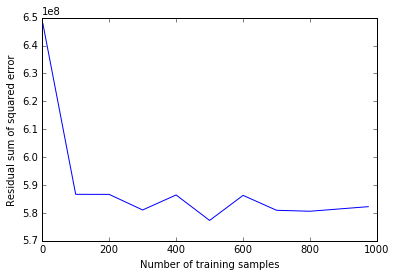

In [8]:
plotPipe(SVR())

In [ ]:
# mod = SVR(C=0.1, kernel='linear')
# plotPipe(mod)

2: 1623285675.6
100: 443726324.569
200: 385961162.662
300: 395558592.718
400: 395068175.205
500: 557135266.098
600: 494923790.091
700: 486289449.874
800: 454686386.226
974: 446144048.094


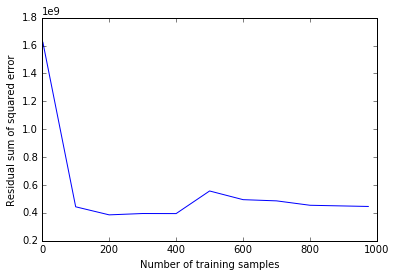

In [9]:
from sklearn.kernel_ridge import KernelRidge

mod = KernelRidge(alpha=.1, kernel="linear")
plotPipe(mod)

2: 5121015175.59
100: 4948222912.6
200: 4904145416.24
300: 4774260486.39
400: 4670214970.08
500: 4614222201.97
600: 4519876455.02
700: 4525393043.46
800: 4418694244.21
974: 4303659497.73


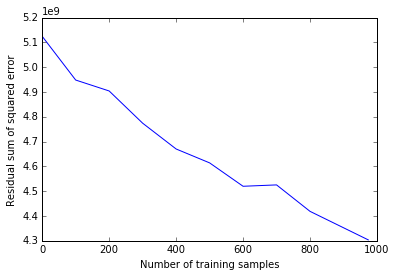

In [18]:
mod = KernelRidge(alpha=0.05, kernel="rbf")
plotPipe(mod)

2: 16592157732.4
100: 1.93133784939e+14
200: 3.24453439562e+13
300: 340867842210.0
400: 7629783717.78
500: 3582970625.63
600: 281336766.573
700: 4455545526.57
800: 986216890.229
974: 818503426.55


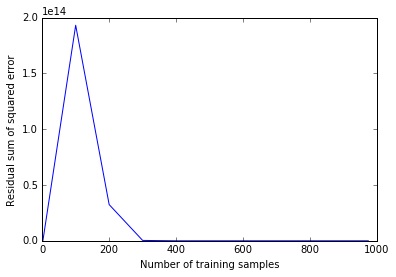

In [19]:
mod = KernelRidge(alpha=0.1, kernel="poly")
plotPipe(mod)

In [63]:
final = KernelRidge(alpha=.1, kernel="linear")
l = pullListings()
feats, labels = featurized(l)
final.fit(feats, labels)

KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)

In [60]:
import requests
from lxml import html
import time

def linkToVector(link):
    
        r = requests.get(link)
        response = tree = html.fromstring(r.text)
        
        item = {}
        curr = response.xpath("//*[@id='pagecontainer']/section/section/div[2]/p[2]/time/text()")[0].split()[0]
        item["postingDate"] = int(time.mktime(datetime.datetime.strptime(curr, "%Y-%m-%d").timetuple()))
        #pre-processing for getting the price in the right format
        #item["area"] = ''.join(temp.xpath("span")[2].xpath("span[@class='pnr']").xpath("small/text()").extract())
        item["price"] = int(response.xpath("//*[@id='pagecontainer']/section/h2/span[2]/span[1]/text()")[0].replace("$",""))#price.replace("$","")

        maplocation = response.xpath("//div[contains(@id,'map')]")
        latitude = ''.join(maplocation[0].xpath('@data-latitude'))
        longitude = ''.join(maplocation[0].xpath('@data-longitude'))
        tmp = response.xpath("//*[@id='pagecontainer']/section/section/div[1]/div[1]/div[2]/text()")
        if len(tmp) > 0:
            item['address'] = tmp[0]
        if latitude:
            item['latitude'] = float(latitude)
        if longitude:
            item['longitude'] = float(longitude)
        #attr = response.xpath("//p[@class='attrgroup']")
    try:
        item["bedrooms"] = int(response.xpath("//*[@id='pagecontainer']/section/section/div[1]/p[1]/span[1]/b[1]/text()")[0])#int(attr.xpath("span/b/text()")[0])
        #bath = attr.xpath("span/b/text()")[1]
        item["sqft"] = int(response.xpath("//*[@id='pagecontainer']/section/section/div[1]/p[1]/span[2]/b/text()")[0])
        #int(''.join(attr.xpath("span")[1].xpath("b/text()")))
        #if(bath.isdigit()):
        item["bathrooms"] = int(response.xpath("//*[@id='pagecontainer']/section/section/div[1]/p[1]/span[1]/b[2]/text()")[0])#int(attr.xpath("span/b/text()")[1])
         except:
            pass
        item['description'] = "".join(response.xpath("//section[@id='postingbody']/text()"))#.xpath("text()")) 
        item["numImages"] = len(response.xpath("//div[@id='thumbs']/a"))#.xpath("a"))
        return featurize(item)


In [61]:
linkToVector("https://sfbay.craigslist.org/eby/apa/5507931799.html")

[4, 3, 2960, 1.5424443921241437, 18, 330, 7]

In [66]:
def predictionFromLink(link, model):
    vector = linkToVector(link)
    return model.predict(vector)

predictionFromLink("https://sfbay.craigslist.org/eby/apa/5507931799.html", final)

/Users/aakashjapi/HousingAnalysisDailyCal/venv/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 7681.65284061])

In [68]:
predictionFromLink("https://sfbay.craigslist.org/eby/apa/5517648696.html", final)

/Users/aakashjapi/HousingAnalysisDailyCal/venv/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 2629.42505646])